# Electricity Demand Prediction Using Simple Neural Network

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow.python.framework import ops
import math

## Loading Processed Data

In [22]:
X_train1 = np.loadtxt('X_train1.txt', dtype=float)
X_train2 = np.loadtxt('X_train2.txt', dtype=float)
X_val1 = np.loadtxt('X_val1.txt', dtype=float)
X_val2 = np.loadtxt('X_val2.txt', dtype=float)
X_test1 = np.loadtxt('X_test1.txt', dtype=float)
X_test2 = np.loadtxt('X_test2.txt', dtype=float)
y_train = np.loadtxt("y_train.txt", dtype=float)
y_val = np.loadtxt("y_val.txt", dtype=float)
y_test = np.loadtxt("y_test.txt", dtype=float)
y_train/=1000#np.max(y_train)
y_test/=1000#np.max(y_test)
y_val/=1000#np.max(y_val)

In [23]:
X_train1.T.shape, y_train[np.newaxis].shape

((168, 5103), (1, 5103))

## Preparing Data for Neural Network Input

In [24]:
X_train = np.concatenate((X_train1, X_train2), axis=1)
X_val = np.concatenate((X_val1, X_val2), axis=1)

X_train = X_train.T
X_val = X_val.T

y_train=y_train[np.newaxis]
y_val=y_val[np.newaxis]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((200, 5103), (200, 1458), (1, 5103), (1, 1458))

## Creating the Neural Network

In [25]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(shape=[n_x, None], dtype=tf.float32)
    Y = tf.placeholder(shape=[n_y, None], dtype=tf.float32)
    return X, Y



In [26]:
X, Y = create_placeholders(12288, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder_6:0", shape=(12288, ?), dtype=float32)
Y = Tensor("Placeholder_7:0", shape=(6, ?), dtype=float32)


In [27]:
def initialize_parameters(n_x, n_y, layers=4, layers_dim=[512, 512, 512, 1]):
    
    tf.set_random_seed(1)
    parameters={}
    for l in range(layers):
        if l == 0:
            parameters["W"+str(l+1)] = tf.get_variable("W"+str(l+1), [layers_dim[l], n_x], initializer=tf.contrib.layers.xavier_initializer(seed = 1))
            parameters["b"+str(l+1)] = tf.get_variable("b"+str(l+1), [layers_dim[l], 1], initializer=tf.zeros_initializer())
        else:
            parameters["W"+str(l+1)] = tf.get_variable("W"+str(l+1), [layers_dim[l], layers_dim[l-1]], initializer=tf.contrib.layers.xavier_initializer(seed = 1))
            parameters["b"+str(l+1)] = tf.get_variable("b"+str(l+1), [layers_dim[l], 1], initializer=tf.zeros_initializer())
    
    return parameters
#     W1 = tf.get_variable("W1", [25,12288], initializer=tf.contrib.layers.xavier_initializer(seed = 1))
#     b1 = tf.get_variable("b1", [25, 1], initializer=tf.zeros_initializer())
#     W2 = tf.get_variable("W2", [12, 25], initializer=tf.contrib.layers.xavier_initializer(seed = 1))
#     b2 = tf.get_variable("b2", [12, 1], initializer=tf.zeros_initializer())
#     W3 = tf.get_variable("W3", [6, 12], initializer=tf.contrib.layers.xavier_initializer(seed = 1))
#     b3 = tf.get_variable("b3", [6, 1], initializer=tf.zeros_initializer())

In [28]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters(12288, 6)
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))
    print("W3 = " + str(parameters["W3"]))
    print("b3 = " + str(parameters["b3"]))
    print("W4 = " + str(parameters["W4"]))
    print("b4 = " + str(parameters["b4"]))

W1 = <tf.Variable 'W1:0' shape=(512, 12288) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(512, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(512, 512) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(512, 1) dtype=float32_ref>
W3 = <tf.Variable 'W3:0' shape=(512, 512) dtype=float32_ref>
b3 = <tf.Variable 'b3:0' shape=(512, 1) dtype=float32_ref>
W4 = <tf.Variable 'W4:0' shape=(1, 512) dtype=float32_ref>
b4 = <tf.Variable 'b4:0' shape=(1, 1) dtype=float32_ref>


## Forward Propogation

In [29]:
def forward_propagation(X, parameters, activation_types=["relu","relu","relu","relu"]):
    mul = {}
    L = int(len(parameters)/2)
    for l in range(L):
        if l == 0:
            mul["Z"+str(l+1)] = parameters["W"+str(l+1)] @ X + parameters["b"+str(l+1)]
        else:
            mul["Z"+str(l+1)] = parameters["W"+str(l+1)] @ mul["A"+str(l)] + parameters["b"+str(l+1)]
        if activation_types[l] == "relu":
            mul["A"+str(l+1)] = tf.nn.relu(mul["Z"+str(l+1)])
        elif activation_types[l] == "sigmoid":
            mul["A"+str(l+1)] = tf.nn.sigmoid(mul["Z"+str(l+1)])
        else:
            mul["A"+str(l+1)] = mul["Z"+str(l+1)]
        
    return mul["A"+str(int(len(parameters)/2))]
    

## Loss Calculation

In [30]:
def compute_cost(AL, Y, cost_type="mse"):
#     m = Y.shape[0]
    cost = tf.reduce_mean((AL-Y)**2)
    return cost

## Setting up the Network Model

In [31]:
def random_minibatches(X, Y, mini_batch_size=64, seed=1):
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, k*mini_batch_size: (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size: (k+1)*mini_batch_size]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches
    

## Model Training

Cost after epoch 0: 15.129735
Cost after epoch 50: 0.320626
Cost after epoch 100: 0.251077
Cost after epoch 150: 0.232174


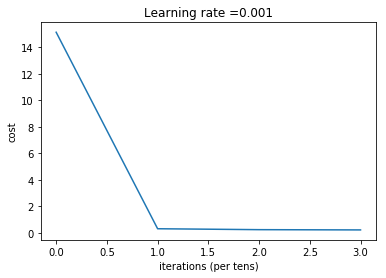

Train accuracy:  -0.007369212
Test accuracy:  -0.009030818


In [32]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.001, num_epochs=200, print_cost=True, mini_batch_size=64):
    ops.reset_default_graph()
#     tf.set_random_seed(1)
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    costs=[]
    
    X, Y = create_placeholders(n_x, n_y)
    
    parameters = initialize_parameters(n_x, n_y)
    
    AL = forward_propagation(X, parameters)
    
    cost = compute_cost(AL, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.
            num_minibatches = m/mini_batch_size
            minibatches = random_minibatches(X_train, Y_train)
            for minibatch in minibatches:
                minibatch_X, minibatch_Y = minibatch
                _, minibatch_cost = sess.run((optimizer, cost), feed_dict={X:minibatch_X, Y:minibatch_Y})
                epoch_cost += minibatch_cost/num_minibatches
                
            if print_cost == True:
                if epoch%50==0:
                    costs.append(epoch_cost)
                    if epoch%50==0:
                        print("Cost after epoch %i: %f" % (epoch, epoch_cost))
                        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        parameters = sess.run(parameters)
        accuracy = tf.reduce_mean(1-AL/Y)

        print("Train accuracy: ", accuracy.eval({X: X_train, Y: Y_train}))
        print("Test accuracy: ", accuracy.eval({X: X_test, Y: Y_test}))
    
    return parameters

parameters = model(X_train, y_train, X_val, y_val)

## Accuracy Testing

In [33]:
X_test = np.concatenate((X_test1, X_test2), axis=1)
X_test = X_test.T
y_test=y_test.reshape(1, -1)

with tf.Session() as sess:
    X, Y = create_placeholders(200, 1)
    AL = forward_propagation(X, parameters)
#     print(tf.Variable(AL, validate_shape=False).eval())
#     pred = tf.reduce_uniform(AL)
#     print(pred)
    pred = (AL.eval({X: X_test}))
    accuracy = tf.reduce_mean(tf.abs(1-AL/Y))
    mse_test = tf.reduce_mean((AL-Y)**2).eval({X: X_test, Y: y_test})
    mse_train = tf.reduce_mean((AL-Y)**2).eval({X: X_train, Y: y_train})
    mse_val = tf.reduce_mean((AL-Y)**2).eval({X: X_val, Y: y_val})
    print("Train accuracy: ", (1-accuracy.eval({X: X_train, Y: y_train}))*100,"%")
    print("Validation accuracy: ", (1-accuracy.eval({X: X_val, Y: y_val}))*100,"%")
    print("Test accuracy: ", (1-accuracy.eval({X: X_test, Y: y_test}))*100,"%")

Train accuracy:  96.33717648684978 %
Validation accuracy:  96.0184708237648 %
Test accuracy:  95.24973146617413 %


In [34]:
print('Train MSE:', mse_train)
print('Val MSE:', mse_val)
print('Test MSE:', mse_test)

Train MSE: 0.21265689
Val MSE: 0.26750866
Test MSE: 0.39386454


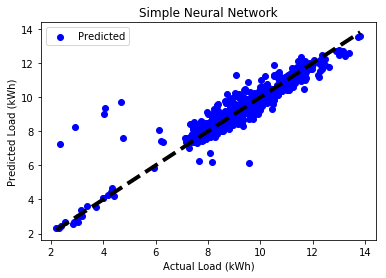

In [35]:
def plot(x,y,x_label=None,y_label=None, title=None, style1=None, color1=None, label1=None, y2=None, label2=None, \
           style2=None, color2=None):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plot1 = plt.scatter(x, y, color=color1)
    plot2, = plt.plot([(y_test).min(), (y_test).max()], [(y_test).min(), (y_test).max()], 'k--', lw=4)
    plt.legend([plot1], [label1, label2])
    plt.show()
    
plot(y_test, pred, 'Actual Load (kWh)', 'Predicted Load (kWh)',  'Simple Neural Network', \
       style1='.', color1='blue', label1='Predicted', y2=y_test, label2='Actual', \
       style2='--', color2='black')
